# Grid Compliance LLM Pipeline - Data Exploration

This notebook explores the data pipeline for the Grid Compliance QA Assistant. It covers:

1. **Database Overview**: Chunks extracted from PDFs
2. **Training Dataset Analysis**: QA pairs generated by tier
3. **Data Quality Checks**: Sample review and statistics
4. **Visualization**: Distribution charts

---

In [2]:
!pip install matplotlib seaborn

In [3]:
# Setup and Imports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Project paths
PROJECT_ROOT = Path.cwd().parent
DB_PATH = PROJECT_ROOT / "data" / "pipeline.db"

print(f"Database path: {DB_PATH}")
print(f"Database exists: {DB_PATH.exists()}")

Database path: /workspaces/automated-grid-compliance-llm-pipeline/data/pipeline.db
Database exists: True


## 1. Document Chunks Overview

First, let's explore the document chunks extracted from the PDFs.

In [18]:
# Load document chunks from database
conn = sqlite3.connect(DB_PATH)

# Get all chunks
chunks_df = pd.read_sql_query("""
    SELECT id, source_file, page_number, content, LENGTH(content) as content_length
    FROM document_chunks
""", conn)

print(f"Total document chunks: {len(chunks_df)}")
print(f"\nChunks by source:")
print(chunks_df.groupby('source_file').size())
chunks_df.head()

Total document chunks: 74

Chunks by source:
source_file
G99_Issue_2.pdf            59
SPEN_EV_Fleet_Guide.pdf     8
UKPN_EDS_08_5050.pdf        7
dtype: int64


,id,source_file,page_number,content,content_length
0,1,G99_Issue_2.pdf,26,"ENA and Department for Business, Energy and In...",2473
1,2,G99_Issue_2.pdf,27,system of the associated Steam Unit(s) or Stea...,2273
2,3,G99_Issue_2.pdf,28,Droop\n\nThe ratio of the per unit steady stat...,2370
3,4,G99_Issue_2.pdf,29,Final Operational Notification (FON)\n\nA noti...,2849
4,5,G99_Issue_2.pdf,30,Generator's Installation\n\nThe electrical i...,2641


In [23]:
# Explore chunks for a specific source file with simple pagination
source_name = "SPEN_EV_Fleet_Guide.pdf"  # change to any source_file in chunks_df
# page_size = 15                   # number of chunks per page
start = 0                        # set to 0, 15, 30, ... to view next pages

def display_chunks(source_file: str, start_idx: int = 0, limit: int = 60):
    filtered = (
    chunks_df[chunks_df["source_file"] == source_file]
    .sort_values(["page_number", "id"])
    .reset_index(drop=True)
    )
    end_idx = start_idx + limit
    print(f"Source: {source_file}")
    print(f"Total chunks: {len(filtered)} | Showing {start_idx} to {min(end_idx, len(filtered)) - 1}")

    page = filtered.iloc[start_idx:end_idx][["id", "page_number", "content_length", "content"]]
    return page

selected_chunks = display_chunks(source_name, start)
selected_chunks

Source: SPEN_EV_Fleet_Guide.pdf
Total chunks: 8 | Showing 0 to 7


,id,page_number,content_length,content
0,67,5,1946,Understanding Your Demand Profile\n\nBefore de...
1,68,6,2058,Calculating your Fleet Charging Requirements\n...
2,69,10,1557,OPTIONS TO CONSIDER\n\nLoad Management\n\nLoad...
3,70,11,1997,OPTIONS TO CONSIDER\n\nOn-site Generation and ...
4,71,12,1085,CASE STUDY\n\nExample 1 - Small Connection\n\n...
5,72,13,905,Example 2 - Large non-firm/flexible connection...
6,73,14,1496,CASE STUDY\n\nExample 3 - Large connection\n\n...
7,74,15,6805,GLOSSARY OF TERMS\n\n| Term ...


In [24]:
for idx, row in selected_chunks.iterrows():
    print(f"\n--- Chunk ID: {row['id']} | Page: {row['page_number']} | Length: {row['content_length']} ---")
    print(row['content'])
    print("\n")


--- Chunk ID: 67 | Page: 5 | Length: 1946 ---
Understanding Your Demand Profile

Before deciding on whether you need to upgrade your existing electricity connection to accommodate the additional load requirements from electric vehicle charge points, you will need to establish how much electricity you are currently consuming on your site (i.e. your Maximum Demand) and at what times.

You should then check this against your Authorised Capacity for the site, as set out in your connection agreement (i.e. the capacity that you are authorised to use as part of your agreement with your DNO).

This will determine if you have available capacity to accommodate all, or part, of the additional load from your proposed EV charge points. While the provision of a single EV charger to support one or two vehicles may not be an issue, connecting multiple commercial vehicles will normally require an assessment of the electricity network. You should therefore contact your DNO to discuss whether an increas

In [7]:
# Statistics by source
stats_df = chunks_df.groupby('source_file').agg({
    'id': 'count',
    'content_length': ['mean', 'min', 'max', 'sum'],
    'page_number': ['min', 'max', 'nunique']
}).round(1)

stats_df.columns = ['chunk_count', 'avg_length', 'min_length', 'max_length', 
                    'total_chars', 'min_page', 'max_page', 'unique_pages']
stats_df

,chunk_count,avg_length,min_length,max_length,total_chars,min_page,max_page,unique_pages
source_file,,,,,,,,
G99_Issue_2.pdf,903,143.7,1,1626,129745,26,319,59
SPEN_EV_Fleet_Guide.pdf,153,139.0,2,1036,21266,5,15,8
UKPN_EDS_08_5050.pdf,270,63.8,1,1292,17229,8,17,7


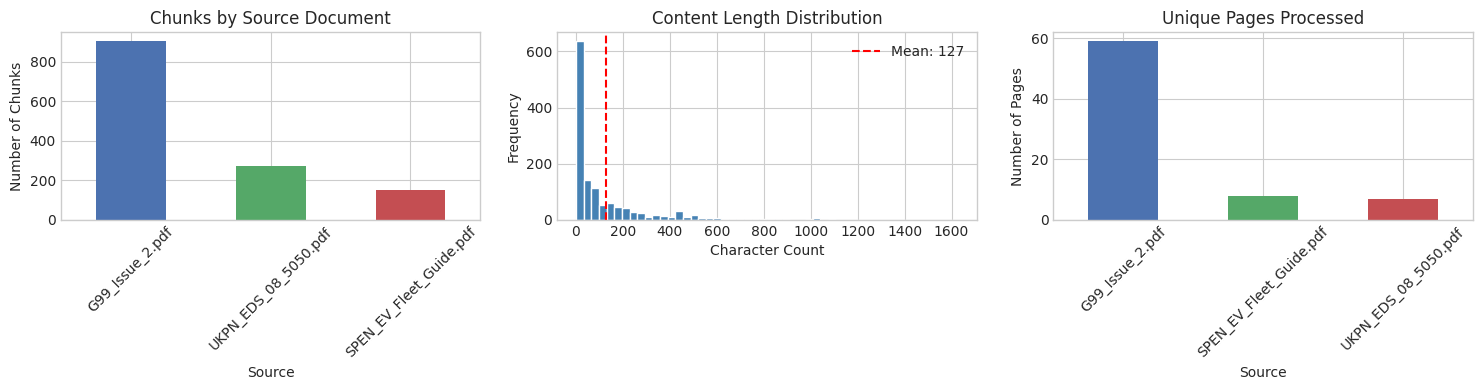

In [8]:
# Visualize chunk distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Chunks per source
chunks_df['source_file'].value_counts().plot(kind='bar', ax=axes[0], color=['#4C72B0', '#55A868', '#C44E52'])
axes[0].set_title('Chunks by Source Document')
axes[0].set_xlabel('Source')
axes[0].set_ylabel('Number of Chunks')
axes[0].tick_params(axis='x', rotation=45)

# Content length distribution
chunks_df['content_length'].hist(bins=50, ax=axes[1], color='steelblue', edgecolor='white')
axes[1].set_title('Content Length Distribution')
axes[1].set_xlabel('Character Count')
axes[1].set_ylabel('Frequency')
axes[1].axvline(chunks_df['content_length'].mean(), color='red', linestyle='--', label=f"Mean: {chunks_df['content_length'].mean():.0f}")
axes[1].legend()

# Pages per source
page_counts = chunks_df.groupby('source_file')['page_number'].nunique()
page_counts.plot(kind='bar', ax=axes[2], color=['#4C72B0', '#55A868', '#C44E52'])
axes[2].set_title('Unique Pages Processed')
axes[2].set_xlabel('Source')
axes[2].set_ylabel('Number of Pages')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 2. Sample Content Review

Let's examine some sample chunks from each source to verify extraction quality.

In [9]:
# Sample chunks from each source
for source in chunks_df['source_file'].unique():
    print(f"\n{'='*60}")
    print(f"📄 {source}")
    print('='*60)
    
    samples = chunks_df[chunks_df['source_file'] == source].sample(min(3, len(chunks_df[chunks_df['source_file'] == source])))
    
    for _, row in samples.iterrows():
        print(f"\n[Page {row['page_number']}] ({row['content_length']} chars)")
        print(f"Content: {row['content'][:200]}..." if len(row['content']) > 200 else f"Content: {row['content']}")
        print("-" * 40)


📄 G99_Issue_2.pdf

[Page 39] (51 chars)
Content: 3 x 2 kW Type A Synchronous Power Generating Module
----------------------------------------

[Page 27] (277 chars)
Content: system of the associated Steam Unit(s) or Steam Units and where the component units within the CCGT Module are directly connected by steam or hot gas lines which  enable  those  units  to  contribute ...
----------------------------------------

[Page 76] (460 chars)
Content: 7.5.3 Where single phase Power Generating Module s are being used the Generator should design the installation on a maximum unbalance output of 32 A between the highest and lowest phase. Where there i...
----------------------------------------

📄 UKPN_EDS_08_5050.pdf

[Page 12] (62 chars)
Content: It is the responsibility of the EVCP installer to ensure that:
----------------------------------------

[Page 9] (8 chars)
Content: Earthing
----------------------------------------

[Page 17] (10 chars)
Content: Matt:e Ltd
-----------------------

## 3. Training Dataset Analysis

Now let's examine the generated QA pairs (if they exist).

In [ ]:
# Check if training dataset exists and load it
try:
    qa_df = pd.read_sql_query("""
        SELECT id, chunk_id, source_file, page_number, tier, question, answer, generated_at,
               LENGTH(question) as q_length, LENGTH(answer) as a_length
        FROM training_dataset
        WHERE question != 'N/A'
    """, conn)
    
    print(f"✅ Training dataset found!")
    print(f"Total QA pairs: {len(qa_df)}")
    print(f"\n📊 By Tier:")
    print(qa_df['tier'].value_counts())
    print(f"\n📄 By Source:")
    print(qa_df['source_file'].value_counts())
    
except Exception as e:
    print(f"⚠️ Training dataset not found or empty: {e}")
    print("Run 'python src/generation/qa_generator.py --generate' first!")
    qa_df = None

In [ ]:
# Visualize QA dataset (if available)
if qa_df is not None and len(qa_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # QA pairs by tier
    tier_counts = qa_df['tier'].value_counts()
    colors = ['#4C72B0', '#55A868', '#C44E52']
    tier_counts.plot(kind='pie', ax=axes[0, 0], autopct='%1.1f%%', colors=colors[:len(tier_counts)])
    axes[0, 0].set_title('QA Pairs by Tier', fontsize=12)
    axes[0, 0].set_ylabel('')
    
    # QA pairs by source
    qa_df['source_file'].value_counts().plot(kind='bar', ax=axes[0, 1], color=colors)
    axes[0, 1].set_title('QA Pairs by Source', fontsize=12)
    axes[0, 1].set_xlabel('Source')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Question length distribution
    qa_df['q_length'].hist(bins=30, ax=axes[1, 0], color='steelblue', edgecolor='white')
    axes[1, 0].set_title('Question Length Distribution', fontsize=12)
    axes[1, 0].set_xlabel('Characters')
    axes[1, 0].set_ylabel('Frequency')
    
    # Answer length distribution
    qa_df['a_length'].hist(bins=30, ax=axes[1, 1], color='coral', edgecolor='white')
    axes[1, 1].set_title('Answer Length Distribution', fontsize=12)
    axes[1, 1].set_xlabel('Characters')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
else:
    print("No QA data to visualize")

## 4. Sample QA Pairs by Tier

Let's review sample QA pairs from each tier to assess quality.

In [ ]:
# Display sample QA pairs from each tier
if qa_df is not None and len(qa_df) > 0:
    for tier in qa_df['tier'].unique():
        print(f"\n{'='*70}")
        print(f"🏷️  {tier}")
        print('='*70)
        
        tier_samples = qa_df[qa_df['tier'] == tier].sample(min(2, len(qa_df[qa_df['tier'] == tier])))
        
        for _, row in tier_samples.iterrows():
            print(f"\n📖 Source: {row['source_file']} (Page {row['page_number']})")
            print(f"\n❓ QUESTION:\n{row['question']}")
            print(f"\n✅ ANSWER:\n{row['answer']}")
            print("-" * 70)
else:
    print("No QA data available. Generate it first!")

## 5. Data Quality Summary

Summary statistics and quality checks for the pipeline data.

In [ ]:
# Summary report
print("="*60)
print("📊 PIPELINE DATA SUMMARY")
print("="*60)

print(f"\n📄 DOCUMENT CHUNKS:")
print(f"   Total chunks: {len(chunks_df)}")
print(f"   Total characters: {chunks_df['content_length'].sum():,}")
print(f"   Avg chunk length: {chunks_df['content_length'].mean():.1f} chars")
print(f"   Sources: {chunks_df['source_file'].nunique()}")
print(f"   Pages covered: {chunks_df['page_number'].nunique()}")

if qa_df is not None and len(qa_df) > 0:
    print(f"\n🎯 TRAINING DATASET:")
    print(f"   Total QA pairs: {len(qa_df)}")
    print(f"   Tiers: {qa_df['tier'].nunique()}")
    print(f"   Avg question length: {qa_df['q_length'].mean():.1f} chars")
    print(f"   Avg answer length: {qa_df['a_length'].mean():.1f} chars")
    print(f"\n   By Tier:")
    for tier, count in qa_df['tier'].value_counts().items():
        print(f"     - {tier}: {count}")
else:
    print(f"\n⚠️  TRAINING DATASET: Not generated yet")
    print("   Run: python src/generation/qa_generator.py --generate")

print("\n" + "="*60)

# Close connection
conn.close()